## Observational social learning task with a reinforcement-learning-based network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import pandas as pd
import time
# from RL import *
from RL2 import *

In [2]:
def get_RLz(env, sid, trial, z, b):
    learning_rates = [1, b, b, b]
    human = pd.read_pickle(f"data/human.pkl").query("sid==@sid")
    expectation = 0
    expectations = [0]
    obs_time = 0
    obs_times = [0]
    for stage in range(4):
        subdata = human.query("trial==@trial & stage==@stage")
        observations = subdata['color'].to_numpy()
        RDs = subdata['RD'].to_numpy()
        for o, obs in enumerate(observations):
            stg = int(subdata.iloc[o]['stage'])
            RD = 0 if stg<2 else RDs[o]
            learning_rate = learning_rates[stg]
            error = obs - expectation
            LR = learning_rate + z*RD
            LR = np.clip(LR, 0, 1)
            expectation += LR * error
            expectations.append(expectation)
            obs_time += env.time_sample
            obs_times.append(obs_time)
    return np.array(obs_times), np.array(expectations)

### Direct mode vs spiking LIF

In [2]:
sid = 1
z = 0.2
a = 5e-5
b = 0.3
decay = 'stages'
s = [1,b,b,b]

start = time.time()
for trial in range(1, 3):
    env = Environment(sid=sid, trial=trial, decay=decay, s=s)
    net_dir, sim_dir = simulate_RL(env=env, seed_net=sid, z=z, a=a, progress_bar=False, direct=True)
end = time.time()
print(f"direct runtime={end-start:.4}")

start = time.time()
for trial in range(1, 3):
    env = Environment(sid=sid, trial=trial, decay=decay, s=s)
    net, sim = simulate_RL(env=env, seed_net=sid, z=z, a=a, progress_bar=False)
end = time.time()
print(f"lif runtime={end-start:.4}")

direct runtime=1.483
lif runtime=18.31


### RLz vs Spiking LIF with hand-tuned learning rate $a$

In [17]:
trial = 4
sid = 2
z = 0.09
b = 0.29
a = 5e-5

env = Environment(sid=sid, trial=trial, decay='stages', s=[3,b,b,b])
net, sim = simulate_RL(env=env, seed_net=sid, z=z, a=a, progress_bar=True)
obs_times, RLz = get_RLz(env=env, sid=sid, trial=trial, z=z, b=b)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

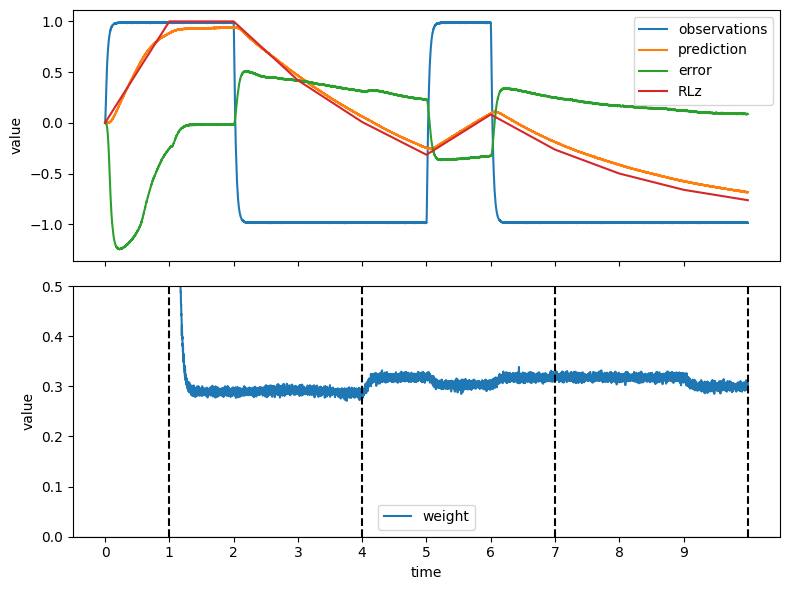

In [18]:
times = sim.trange().flatten()
input_obs = sim.data[net.probe_input].flatten()
obs = sim.data[net.probe_obs].flatten()
# weight = sim.data[net.probe_weight].flatten()
weight = sim.data[net.probe_combined][:,2].flatten()
error = sim.data[net.probe_error].flatten()
prediction = sim.data[net.probe_prediction].flatten()
combined = sim.data[net.probe_combined]
def cumulative_average(a):
    return np.cumsum(a) / np.arange(1, len(a) + 1)
cumavg = cumulative_average(input_obs)

# predictions_direct = sim_dir.data[net_dir.probe_prediction].flatten()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=True)
sns.lineplot(x=times, y=obs, ax=axes[0], label='observations')
sns.lineplot(x=times, y=prediction, ax=axes[0], label='prediction')
sns.lineplot(x=times, y=error, ax=axes[0], label='error')
# sns.lineplot(x=times, y=cumavg, ax=axes[0], label='cumulative average')
# sns.lineplot(x=times, y=math_exp, ax=axes[0], label='math')
# sns.lineplot(x=times, y=prediction_direct, ax=axes[0], label='direct prediction')
sns.lineplot(x=obs_times, y=RLz, ax=axes[0], label='RLz')

sns.lineplot(x=times[100:], y=weight[100:], ax=axes[1], label='weight')
# sns.lineplot(x=times, y=combined[:,0], ax=axes[1], label='combined')
# sns.lineplot(x=times, y=combined[:,1], ax=axes[1], label='combined')
# sns.lineplot(x=times, y=combined[:,2], ax=axes[1], label='combined')

axes[1].axhline(0, color='k', lw=0.1)
axes[1].axvline(env.time_sample, color='k', ls='--')
axes[1].axvline(env.time_sample+env.n_neighbors*env.time_sample, color='k', ls='--')
axes[1].axvline(env.time_sample+2*env.n_neighbors*env.time_sample, color='k', ls='--')
axes[1].axvline(env.time_sample+3*env.n_neighbors*env.time_sample, color='k', ls='--')
axes[0].set(xlabel='time', ylabel='value')
axes[1].set(xlabel='time', ylabel='value', xticks=np.arange(0, env.T+env.dt, env.time_sample), ylim=(0.0, 0.5))  # 
plt.tight_layout()